In [1]:
%matplotlib inline
import utils#; reload(utils)
from utils import *
from __future__ import division, print_function


import os, json
from glob import glob
import numpy as np
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

from keras.utils.data_utils import get_file
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image

from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
Using Theano backend.


In [3]:
#path = "data/fish/sample/"
path = "data/cropped_nof_excl/"
batch_size=32
target_size = (450, 450)

early_stopping  = keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)


In [4]:
(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)

Found 2912 images belonging to 7 classes.
Found 400 images belonging to 7 classes.
Found 12153 images belonging to 1 classes.


In [5]:
raw_filenames = [f.split('/')[-1] for f in filenames]
raw_test_filenames = [f.split('/')[-1] for f in test_filenames]
raw_val_filenames = [f.split('/')[-1] for f in val_filenames]

### Fine tuned VGG

let's look at some of test photos 

In [6]:
gen = image.ImageDataGenerator(rotation_range=10, width_shift_range=0.1, zoom_range=0.1,
                                      channel_shift_range=10, height_shift_range=0.1, shear_range=0.1,
                                      fill_mode='nearest',horizontal_flip=True,vertical_flip=True)

train_flow = gen.flow_from_directory(path+"train", target_size=target_size,
            class_mode="categorical", shuffle=False, batch_size=batch_size)


Found 2912 images belonging to 7 classes.


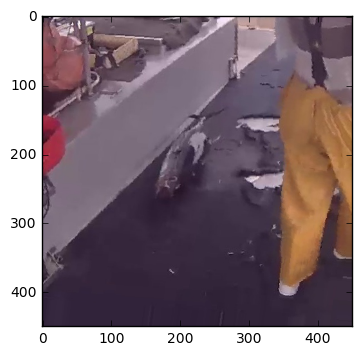

In [6]:
plot(train_flow.next()[0][5])

In [7]:
test_flow = ImageDataGenerator().flow_from_directory(path+"test", target_size=target_size,
            class_mode="categorical", shuffle=False, batch_size=batch_size)

Found 12153 images belonging to 1 classes.


In [30]:
nx = test_flow.next()[0]

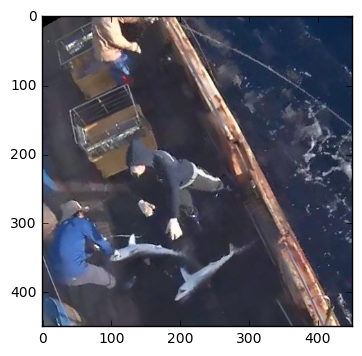

In [36]:
plot(nx[22])

### End to End with precomputations 

In [7]:
# trn = load_array(path+"results/trn_450.dat")
# trn = get_data(path+"train",target_size)
# val = get_data(path+"valid",target_size)

# save_array(path+"results/trn_450.dat", trn)
# save_array(path+"results/val_450.dat", val)

precomputing features up to the second last layer of vgg

In [44]:
vgg_common = Vgg16BN(size=target_size).model
for i in range(5):
    vgg_common.pop()

In [43]:
da_conv_featx2 = vgg_common.predict_generator(train_flow, train_flow.nb_sample)


In [44]:
save_array(path+"results/vggft_aug_da_conv_trn_featx2.dat", da_conv_featx2)
# da_conv_featx2 = load_array(path+"results/vggft_aug_da_conv_trn_featx2.dat")



In [156]:
da_conv_featx2.shape

(5824, 512, 28, 28)

In [11]:
#add normal photos too
# conv_trn_feat = vgg_common.predict(trn,verbose=1)
# save_array(path+"results/conv_trn_feat.dat", conv_trn_feat)


2912/2912 [==============================] - 312s   


In [45]:
da_conv_feat = np.concatenate([conv_trn_feat,da_conv_featx2])

In [19]:
#validation data
# conv_val_feat = vgg_common.predict(val,verbose=2)
# save_array(path+"results/conv_val_feat.dat", conv_val_feat)
conv_val_feat = load_array(path+"results/conv_val_feat.dat")


In [46]:
#target labels
da_trn_labels = np.concatenate([trn_labels]*2)


In [45]:
#build top parts of the model 


nf=128; p=0.

# from keras.layers.pooling import GlobalMaxPooling2D
def get_fcn_layers():
    return [
        
        #default vgg layers
        ZeroPadding2D((1, 1), input_shape=conv_layers[-1].output_shape[1:]),
        Convolution2D(512,3,3, activation='relu'),
        ZeroPadding2D((1, 1)),
        Convolution2D(512,3,3, activation='relu'),

        #new layers
#         BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),
        BatchNormalization(axis=1),

        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D((1,2)),
        Convolution2D(7,3,3, border_mode='same'),
        Dropout(p),
        GlobalAveragePooling2D(),
#         GlobalMaxPooling2D(),
        Activation('softmax')
    ]

In [46]:
conv_layers = vgg_common.layers


In [47]:
model = Sequential(get_fcn_layers())

print (vgg_common.input_shape, vgg_common.output_shape)
print (model.input_shape, model.output_shape)


th
(None, 3, 450, 450) (None, 512, 28, 28)
(None, 512, 28, 28) (None, 7)


In [48]:
for i in range(4):
    print (model.layers[i])
    model.layers[i].trainable = False


In [49]:
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
# vgg_common.summary()

In [33]:
# model.summary()

In [52]:
model.fit(da_conv_feat, da_trn_labels, batch_size=32, nb_epoch=5, 
             validation_data=(conv_val_feat, val_labels))

Train on 5824 samples, validate on 400 samples
Epoch 1/5
5824/5824 [==============================] - 52s - loss: 0.8479 - acc: 0.7155 - val_loss: 1.0021 - val_acc: 0.7125
Epoch 2/5
5824/5824 [==============================] - 52s - loss: 0.3754 - acc: 0.8760 - val_loss: 0.4998 - val_acc: 0.8600
Epoch 3/5
5824/5824 [==============================] - 52s - loss: 0.1634 - acc: 0.9514 - val_loss: 0.3523 - val_acc: 0.9000
Epoch 4/5
5824/5824 [==============================] - 52s - loss: 0.1027 - acc: 0.9679 - val_loss: 0.6326 - val_acc: 0.8425
Epoch 5/5
5824/5824 [==============================] - 52s - loss: 0.0533 - acc: 0.9825 - val_loss: 0.3101 - val_acc: 0.9000


In [53]:
for i in range(4):
    print (model.layers[i])
    model.layers[i].trainable = True

In [54]:
model.optimizer.lr = 1e-6
model.fit(da_conv_feat, da_trn_labels, batch_size=32, nb_epoch=20, 
             validation_data=(conv_val_feat, val_labels))

Train on 5824 samples, validate on 400 samples
Epoch 1/20
5824/5824 [==============================] - 52s - loss: 0.0708 - acc: 0.9772 - val_loss: 0.6763 - val_acc: 0.8125
Epoch 2/20
5824/5824 [==============================] - 52s - loss: 0.0498 - acc: 0.9821 - val_loss: 0.4645 - val_acc: 0.8700
Epoch 3/20
5824/5824 [==============================] - 52s - loss: 0.0412 - acc: 0.9864 - val_loss: 0.2867 - val_acc: 0.9350
Epoch 4/20
5824/5824 [==============================] - 52s - loss: 0.0209 - acc: 0.9931 - val_loss: 0.2957 - val_acc: 0.9300
Epoch 5/20
5824/5824 [==============================] - 52s - loss: 0.0168 - acc: 0.9943 - val_loss: 0.3680 - val_acc: 0.9150
Epoch 6/20
5824/5824 [==============================] - 52s - loss: 0.0298 - acc: 0.9907 - val_loss: 0.3085 - val_acc: 0.9300
Epoch 7/20
5824/5824 [==============================] - 52s - loss: 0.0486 - acc: 0.9845 - val_loss: 0.2769 - val_acc: 0.9225
Epoch 8/20
5824/5824 [==============================] - 52s - loss: 0.0

In [55]:
model.save_weights(path+"models/precompute_aug_ftvgg_0.9525.h5")

In [56]:
model.optimizer.lr = 1e-7
model.fit(da_conv_feat, da_trn_labels, batch_size=32, nb_epoch=10, 
             validation_data=(conv_val_feat, val_labels))

Train on 5824 samples, validate on 400 samples
Epoch 1/10
5824/5824 [==============================] - 51s - loss: 0.0050 - acc: 0.9985 - val_loss: 0.2679 - val_acc: 0.9475
Epoch 2/10
5824/5824 [==============================] - 52s - loss: 0.0074 - acc: 0.9981 - val_loss: 0.2475 - val_acc: 0.9425
Epoch 3/10
5824/5824 [==============================] - 52s - loss: 0.0169 - acc: 0.9940 - val_loss: 0.2740 - val_acc: 0.9350
Epoch 4/10
5824/5824 [==============================] - 52s - loss: 0.0090 - acc: 0.9974 - val_loss: 0.2831 - val_acc: 0.9425
Epoch 5/10
5824/5824 [==============================] - 52s - loss: 0.0195 - acc: 0.9936 - val_loss: 0.3837 - val_acc: 0.9000
Epoch 6/10
5824/5824 [==============================] - 52s - loss: 0.0303 - acc: 0.9900 - val_loss: 0.5114 - val_acc: 0.8875
Epoch 7/10
5824/5824 [==============================] - 52s - loss: 0.0361 - acc: 0.9895 - val_loss: 0.3003 - val_acc: 0.9375
Epoch 8/10
5824/5824 [==============================] - 52s - loss: 0.0

In [50]:
# model.save_weights(path+"models/ftvgg_withprecomputeaug_val_acc_0.9600.h5")
model.load_weights(path+"models/ftvgg_withprecomputeaug_val_acc_0.9600.h5")

best of default vgg: loss: 0.0139 - acc: 0.9979 - val_loss: 0.1453 - val_acc: 0.9650
with top changes without precomputations : 
2912/2912 [==============================] - 364s - loss: 0.0207 - acc: 0.9931 - val_loss: 0.1512 - val_acc: 0.9675


### Pseudo labeling

In [59]:
class MixIterator(object):
    def __init__(self, iters):
        self.iters = iters
        self.multi = type(iters) is list
#         if self.multi:
#             self.N = sum([it[0].N for it in self.iters])
#         else:
        self.N = sum([it.N for it in self.iters])

    def reset(self):
        for it in self.iters: it.reset()

    def __iter__(self):
        return self

    def next(self, *args, **kwargs):
#         if self.multi:
#             nexts = [[next(it) for it in o] for o in self.iters]
#             n0s = np.concatenate([n[0] for n in o])
#             n1s = np.concatenate([n[1] for n in o])
#             return (n0, n1)
#         else:
        nexts = [next(it) for it in self.iters]
        n0 = np.concatenate([n[0] for n in nexts])
        n1 = np.concatenate([n[1] for n in nexts])
        return (n0, n1)


In [ ]:
# trn = get_data(path+"train",target_size)
# val = get_data(path+"valid",target_size)

# save_array(path+"results/trn_450.dat", trn)
# save_array(path+"results/val_450.dat", val)

In [60]:
test = get_data(path+"test",target_size)
save_array(path+"results/test_450.dat", test)

conv_test_feat = vgg_common.predict(test,verbose = 1 )
save_array(path+"results/conv_test_feat.dat", conv_test_feat)


Found 1000 images belonging to 1 classes.
1000/1000 [==============================] - 106s   


In [61]:
val_pseudo = model.predict(conv_val_feat, batch_size=batch_size)
test_pseudo = model.predict(conv_test_feat, batch_size=batch_size)

In [62]:
gen = image.ImageDataGenerator()


trn_batch  = gen.flow(da_conv_feat, da_trn_labels,batch_size=44)
val_batch  = gen.flow(conv_val_feat,val_pseudo,batch_size=4)
test_batch = gen.flow(conv_test_feat,test_pseudo,batch_size=16)


In [63]:
mi = MixIterator([trn_batch, val_batch,test_batch])


In [65]:
model.optimizer.lr = 1e-7
model.fit_generator(mi, mi.N, nb_epoch=10, validation_data=(conv_val_feat, val_labels))


Epoch 1/10
7224/7224 [==============================] - 223s - loss: 0.1627 - acc: 0.9640 - val_loss: 0.2434 - val_acc: 0.9450
Epoch 2/10
7188/7224 [============================>.] - ETA: 1s - loss: 0.1202 - acc: 0.9783

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/engine/training.py:1462: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


7252/7224 [==============================] - 228s - loss: 0.1209 - acc: 0.9784 - val_loss: 0.2035 - val_acc: 0.9600
Epoch 3/10
7252/7224 [==============================] - 223s - loss: 0.0797 - acc: 0.9884 - val_loss: 0.1825 - val_acc: 0.9575
Epoch 4/10
7252/7224 [==============================] - 220s - loss: 0.0744 - acc: 0.9897 - val_loss: 0.1893 - val_acc: 0.9575
Epoch 5/10
7252/7224 [==============================] - 222s - loss: 0.0692 - acc: 0.9903 - val_loss: 0.1788 - val_acc: 0.9525
Epoch 6/10
7260/7224 [==============================] - 224s - loss: 0.0661 - acc: 0.9894 - val_loss: 0.1978 - val_acc: 0.9600
Epoch 7/10
7280/7224 [==============================] - 223s - loss: 0.0676 - acc: 0.9904 - val_loss: 0.1850 - val_acc: 0.9625
Epoch 8/10
7252/7224 [==============================] - 221s - loss: 0.0644 - acc: 0.9891 - val_loss: 0.1827 - val_acc: 0.9600
Epoch 9/10
7252/7224 [==============================] - 223s - loss: 0.0621 - acc: 0.9908 - val_loss: 0.2158 - val_acc: 0.

Pseudo labeling not improving results, not persuing it any further

### Test Augmentation

In [26]:
test_datagen = image.ImageDataGenerator( channel_shift_range=10, horizontal_flip=True,vertical_flip=True)
num_iterations = 5

preds = np.zeros((1000, 7)) #1000 test images, 7 fish types 

for i in range(num_iterations):
    print ("Starting prediction round {}".format(i+1))
    
    test_batches = test_datagen.flow_from_directory (path+"test", target_size=target_size, batch_size=batch_size,
                                                        class_mode=None, shuffle=False)
    
    conv_test_feat = vgg_common.predict_generator(test_batches, 1000)
    
    preds += model.predict(conv_test_feat, batch_size=32)
    
    

Starting prediction round 1
Found 1000 images belonging to 1 classes.
Starting prediction round 2
Found 1000 images belonging to 1 classes.
Starting prediction round 3
Found 1000 images belonging to 1 classes.
Starting prediction round 4
Found 1000 images belonging to 1 classes.
Starting prediction round 5
Found 1000 images belonging to 1 classes.


In [27]:
preds[0:1]

array([[  4.9304e+00,   1.1415e-07,   1.5059e-03,   1.8870e-09,   6.6700e-02,   1.9299e-09,
          1.3820e-03]])

In [28]:
averaged_preds = preds / num_iterations

In [29]:
save_array(path+"results/preds_hvflips_aug_cropped_with_orients_v1.dat",averaged_preds)

stage 2:

In [52]:
test_datagen = image.ImageDataGenerator( channel_shift_range=10, horizontal_flip=True,vertical_flip=True)
num_iterations = 5

preds = np.zeros((len(test_filenames), 7)) #1000 test images, 7 fish types 

for i in range(num_iterations):
    print ("Starting prediction round {}".format(i+1))
    
    test_batches = test_datagen.flow_from_directory (path+"test", target_size=target_size, batch_size=batch_size,
                                                        class_mode=None, shuffle=False)
    
    conv_test_feat = vgg_common.predict_generator(test_batches, len(test_filenames))
    
    preds += model.predict(conv_test_feat, batch_size=32)
    
    save_array(path+"results/stg2_preds_hvflips_aug_cropped_with_orients_v1_part{}.dat".format(i),preds)
    

Starting prediction round 1
Found 12153 images belonging to 1 classes.
Starting prediction round 2
Found 12153 images belonging to 1 classes.
Starting prediction round 3
Found 12153 images belonging to 1 classes.
Starting prediction round 4
Found 12153 images belonging to 1 classes.
Starting prediction round 5
Found 12153 images belonging to 1 classes.


In [54]:
preds[0]

array([  2.0573e+00,   2.6141e-02,   1.3933e-04,   9.8814e-06,   2.8285e-02,   7.8538e-07,
         2.8881e+00])

In [55]:
averaged_preds = preds / num_iterations

In [59]:
save_array(path+"results/stg2_preds_hvflips_aug_cropped_with_orients_v1.dat",averaged_preds)

### VGG with Dense layer on top

Super mild augmentation,
0.04 improvement!

In [38]:
from vgg16bn import Vgg16BN

# vgg_dense = Vgg16BN(size=target_size).model

# vgg_dense.pop()
# print (vgg_dense.input_shape, vgg_dense.output_shape)

# vgg640.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

# conv_layers,fc_layers = split_at(vgg640, Convolution2D)
# conv_model = Sequential(conv_layers)


In [39]:
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        BatchNormalization(axis=1),
        Dropout(p/3),
        Flatten(),
        Dense(2048, activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(2048, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(7, activation='softmax')
    ]

In [11]:
train_datagen = image.ImageDataGenerator(
        shear_range=0.05,
        zoom_range=0.05,
        rotation_range=7,
        width_shift_range=0.07,
        height_shift_range=0.07,
    channel_shift_range=5,
        horizontal_flip=True)


# set shuffle=False if pre-computing

aug_trn_batches = train_datagen.flow_from_directory(path+'train', target_size=target_size,
           class_mode='categorical', shuffle=False, batch_size=batch_size*2)


aug_val_batches = image.ImageDataGenerator().flow_from_directory(path+"valid", target_size=target_size, batch_size=batch_size*2,
                                                   class_mode='categorical', shuffle=False)

Found 2912 images belonging to 7 classes.
Found 400 images belonging to 7 classes.


In [23]:
#precomputing for faster computation 

In [40]:
vgg_dense = Vgg16BN(size=target_size).model

vgg_dense.pop()
print (vgg_dense.input_shape, vgg_dense.output_shape)


(None, 3, 450, 450) (None, 512, 28, 28)


In [25]:
da_conv_featx2 = vgg_dense.predict_generator(aug_trn_batches, aug_trn_batches.nb_sample*2)


In [26]:
da_conv_featx2.shape

(5824, 512, 28, 28)

In [27]:
save_array(path+"results/da_conv_featx2.dat",da_conv_featx2)

In [15]:
conv_trn_feat = load_array(path+'results/conv_trn_450.dat')

In [28]:
conv_trn_feat.shape

(2912, 512, 28, 28)

In [29]:
da_conv_feat = np.concatenate([conv_trn_feat, da_conv_featx2])

In [30]:
da_trn_labels = np.concatenate([trn_labels]*3)
conv_val_feat = load_array(path+'results/conv_val_450.dat')


In [48]:
# memory cleaning
# del conv_val_feat, da_conv_feat,conv_trn_feat,da_conv_featx2

In [41]:
dense_model = Sequential(get_bn_layers(0.6))
dense_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])



In [40]:
dense_model.fit(da_conv_feat, da_trn_labels, batch_size=64, nb_epoch=5, 
             validation_data=(conv_val_feat, val_labels))

Train on 8736 samples, validate on 400 samples
Epoch 1/5
8736/8736 [==============================] - 33s - loss: 0.8483 - acc: 0.8156 - val_loss: 0.5322 - val_acc: 0.9250
Epoch 2/5
8736/8736 [==============================] - 33s - loss: 0.0996 - acc: 0.9752 - val_loss: 0.3817 - val_acc: 0.9575
Epoch 3/5
8736/8736 [==============================] - 33s - loss: 0.0419 - acc: 0.9899 - val_loss: 0.3930 - val_acc: 0.9625
Epoch 4/5
8736/8736 [==============================] - 33s - loss: 0.0353 - acc: 0.9920 - val_loss: 0.3403 - val_acc: 0.9675
Epoch 5/5
8736/8736 [==============================] - 33s - loss: 0.0326 - acc: 0.9930 - val_loss: 0.3397 - val_acc: 0.9575


In [42]:
dense_model.optimizer.lr = 1e-5
dense_model.fit(da_conv_feat, da_trn_labels, batch_size=64, nb_epoch=3, 
             validation_data=(conv_val_feat, val_labels))

Train on 8736 samples, validate on 400 samples
Epoch 1/3
8736/8736 [==============================] - 33s - loss: 0.0347 - acc: 0.9910 - val_loss: 0.3026 - val_acc: 0.9625
Epoch 2/3
8736/8736 [==============================] - 33s - loss: 0.0200 - acc: 0.9938 - val_loss: 0.2869 - val_acc: 0.9650
Epoch 3/3
8736/8736 [==============================] - 33s - loss: 0.0382 - acc: 0.9904 - val_loss: 0.3190 - val_acc: 0.9525


In [43]:
dense_model.optimizer.lr = 1e-7
dense_model.fit(da_conv_feat, da_trn_labels, batch_size=64, nb_epoch=3, 
             validation_data=(conv_val_feat, val_labels))

Train on 8736 samples, validate on 400 samples
Epoch 1/3
8736/8736 [==============================] - 34s - loss: 0.0237 - acc: 0.9942 - val_loss: 0.3196 - val_acc: 0.9675
Epoch 2/3
8736/8736 [==============================] - 33s - loss: 0.0294 - acc: 0.9936 - val_loss: 0.2976 - val_acc: 0.9625
Epoch 3/3
8736/8736 [==============================] - 33s - loss: 0.0234 - acc: 0.9937 - val_loss: 0.2968 - val_acc: 0.9625


In [42]:
# dense_model.save_weights(path+"models/dense_precomputed_aug_1e7_val_acc_0.9625.h5")

dense_model.load_weights(path+"models/dense_precomputed_aug_1e7_val_acc_0.9625.h5")


#### Making predictions
    

In [43]:
predictions = np.zeros(shape=(1000, 7))

nb_aug = 5
for aug in range(nb_aug):
    
    test_batches = test_datagen.flow_from_directory(path+"test", target_size=target_size,
                class_mode=None, shuffle=False, batch_size=32)


    conv_test_feat = vgg_dense.predict_generator(test_batches, 1000)
    predictions += dense_model.predict(conv_test_feat, batch_size=32)
    
    print ("finished prediction round ", aug+1)
predictions /= nb_aug

Found 1000 images belonging to 1 classes.
finished prediction round  1
Found 1000 images belonging to 1 classes.
finished prediction round  2
Found 1000 images belonging to 1 classes.
finished prediction round  3
Found 1000 images belonging to 1 classes.
finished prediction round  4
Found 1000 images belonging to 1 classes.
finished prediction round  5


In [44]:
# save_array(path+"results/preds_dense_precomputed_aug_1e7_val_acc_0.9625.dat",predictions)

save_array(path+"results/preds_dense_precomputed_aug_1e7_val_acc_0.9625_orient_crops_v1.dat",predictions)

### Submission

In [45]:
import pandas as pd

classes = ['ALB', 'BET', 'DOL', 'LAG','NoF', 'OTHER', 'SHARK', 'YFT']
# nofish_prob = load_array("data/fishnofish/results/preds_640_loss_0.0244_acc_0.9913_val_loss_0.2086_val_acc_0.9778.dat")
# nofish_prob = load_array("data/fishnofish/results/pred_stg1_fullconv_aug_no_pseudo.dat")
# nofish_prob = load_array("data/fishnofish/results/final_stg1_weights_ensumble.dat")

nofish_prob = load_array("data/fishnofish/results/final_stg1_weights_ensumble_with_pseudo.dat")



nofish_prob = nofish_prob[:, 1] #nofish class


In [50]:
# preds_vanilla = load_array(path+"results/preds_dense_vanilla_1e3.dat") >> made it worse by 0.07 point
#preds_denseaug_orient_crop_hvflipaugs = load_array(path+"results/preds_dense_precomputed_aug_1e7_val_acc_0.9625_orient_crops_v1.dat") 
#>> made it worse by 0.02 points


preds_fcn_light_aug = load_array(path+"results/preds_light_aug_cropped_v1.dat")
preds_light_aug_denseaug = load_array(path+"results/preds_dense_precomputed_aug_1e7_val_acc_0.9625.dat") #>>made it better by 0.02 points

preds_fcn_orient_crop_hvflipaugs = load_array(path+"results/preds_hvflips_aug_cropped_with_orients_v1.dat") ## from 0.89473 to 0.86956


subm_name = path+'submit/preds_cropped_ensumble_fcc_and_dense_for_orient_n_noorient.gz'



In [51]:
preds = preds_fcn_light_aug + preds_light_aug_denseaug + preds_fcn_orient_crop_hvflipaugs


preds /= 3

In [52]:
def weight_predictions(predictions):
    """Weights predictions based on probability image contains a fish as predicted by fish detector model"""
    no_fish = predictions[:, 4]
    fish = np.delete(predictions, 4, axis=1)

    weights = -1. * (no_fish - 1.)
    weights = weights.reshape(1000, 1)

    fish = weights * fish
    preds = np.insert(fish, 4, no_fish, axis=1)

    return preds


In [53]:
with_nofish_probs = np.insert(preds, 4, nofish_prob, axis=1)
weighted_preds = weight_predictions(with_nofish_probs)

In [54]:
f = 0.85#0.82
subm = np.clip(weighted_preds, (1-f)/7, f)

In [55]:
submission = pd.DataFrame(subm, columns=classes)
submission.insert(0, 'image', raw_test_filenames)
submission.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_06237.jpg,0.850000,0.021429,0.021429,0.021429,0.021429,0.021429,0.021429,0.021429
1,img_06893.jpg,0.604217,0.021429,0.021429,0.021429,0.021429,0.021429,0.021429,0.362154
2,img_02082.jpg,0.386742,0.021429,0.021429,0.021429,0.582517,0.021429,0.021429,0.029171
3,img_06261.jpg,0.850000,0.021429,0.021429,0.021429,0.021429,0.021429,0.021429,0.125574
4,img_03628.jpg,0.850000,0.021429,0.021429,0.021429,0.021429,0.021429,0.021429,0.021429


In [56]:
submission.to_csv(subm_name, index=False, compression='gzip')
FileLink(subm_name)

/home/ubuntu/fish/data/cropped_nof_excl/submit/preds_cropped_ensumble_fcc_and_dense_for_orient_n_noorient.gz